In [1]:
import argparse
from pathlib import Path
from data_processing import DataProcessor
from models import ModelTrainer
from feature_selection import FeatureSelector
from visualization import Visualizer
from causal_inference import CausalInference
import shap
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from causal_inference import CausalInference
from evaluation import iterative_feature_deletion_with_avg_output_regression, iterative_feature_addition_with_avg_output_regression


import warnings
warnings.filterwarnings("ignore")



c:\Users\snorl\Desktop\FYP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Starting ML Pipeline...")
base_dir = '../../../'
print(f"Base directory set to: {base_dir}")

data_path = base_dir + 'dataset/' + 'data_full.xlsx'
raw_data_path = base_dir + 'dataset/' + 'result_raw.xlsx'
result_dir = base_dir + 'result/R/'

report_file_path = result_dir + 'report.txt'

print("Loading data...")
data_processor = DataProcessor(data_path=str(data_path))
df = data_processor.load_data_metabolites()
print("Data loaded successfully.")

Starting ML Pipeline...
Base directory set to: ../../../
Loading data...
Data loaded successfully.


In [3]:
print("Preprocessing raw data...")
raw_df = data_processor.preprocess_raw_data(raw_data_path=str(raw_data_path))
print("Raw data preprocessed successfully.")

print("Encoding labels...")
df_encoded, label_encoder = data_processor.encode_labels(df, label_column='Group')
print("Labels encoded successfully.")

X = df_encoded.drop(columns=['Group'])
y = df_encoded['Group']

print("Training Random Forest model...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}
model_trainer = ModelTrainer(X, y)
model, best_params = model_trainer.train_random_forest(param_dist)
print("Model trained successfully.")

Preprocessing raw data...
Raw data preprocessed successfully.
Encoding labels...
Labels encoded successfully.
Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Model trained successfully.


In [4]:
print("Evaluating model...")
accuracy, report = model_trainer.evaluate_model()
print("Model evaluation completed.")

print("Saving trained model...")
model_trainer.save_model(str(result_dir + 'best_random_forest_model.pkl'))
print("Model saved successfully.")



Evaluating model...
Model evaluation completed.
Saving trained model...
Model saved successfully.


In [5]:
print("Performing feature selection using Gini importance...")
feature_selector = FeatureSelector(model, model_trainer.X_train)
selected_features_gini = feature_selector.gini_importance(threshold=0.001)
sorted_features = selected_features_gini.sort_values(ascending=False)

top_30_features = sorted_features.head(30)

print("Top 30 features selected based on Gini importance:")
print(top_30_features.to_list())


Performing feature selection using Gini importance...
Top 30 features selected based on Gini importance:
['xylose', 'xanthosine', 'valylglutamine', 'valine betaine', 'ursodeoxycholate sulfate (1)', 'uracil', 'tyrosine', 'tryptophylglycine', "trigonelline (N'-methylnicotinate)", 'tricarballylate', 'thymine', 'threonine', 'thiamin (Vitamin B1)', 'theobromine', 'syringic acid', 'succinimide', 'succinate', 'stearate (18:0)', 'stachydrine', 'sphingosine', 'serotonin', 'serine', 'salicylate', 'saccharin', 'ribulose/xylulose', 'riboflavin (Vitamin B2)', 'ribitol', 'quinolinate', 'quinate', 'pyroglutamine*']


In [6]:
X = X[['xylose', 'xanthosine', 'valylglutamine', 'valine betaine', 'ursodeoxycholate sulfate (1)', 'uracil', 'tyrosine', 'tryptophylglycine', "trigonelline (N'-methylnicotinate)", 'tricarballylate', 'thymine', 'threonine', 'thiamin (Vitamin B1)', 'theobromine', 'syringic acid', 'succinimide', 'succinate', 'stearate (18:0)', 'stachydrine', 'sphingosine', 'serotonin', 'serine', 'salicylate', 'saccharin', 'ribulose/xylulose', 'riboflavin (Vitamin B2)', 'ribitol', 'quinolinate', 'quinate', 'pyroglutamine*']]
y = df_encoded['Group']

print("Training Random Forest model...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}
model_trainer = ModelTrainer(X, y)
model, best_params = model_trainer.train_random_forest(param_dist)

Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [7]:
print("Applying SHAP for explainability...")

# Use KMeans background data for SHAP Kernel Explainer
background_data = shap.kmeans(model_trainer.X_train, 100)
explainer = shap.KernelExplainer(model.predict_proba, background_data)

# Calculate SHAP values
shap_values = explainer.shap_values(model_trainer.X_test)

Applying SHAP for explainability...


100%|██████████| 74/74 [03:50<00:00,  3.12s/it]


[[ 0.07473079 -0.00075865  0.01159311 ... -0.00214633  0.01774153
  -0.00335469]
 [ 0.09807784 -0.00034284  0.00104683 ... -0.00020379 -0.00729033
  -0.00476341]
 [ 0.07512686 -0.00214802 -0.00090148 ...  0.00071665  0.01870342
  -0.00152434]
 ...
 [ 0.081697   -0.00837484 -0.00320905 ...  0.00078113 -0.00341922
  -0.01083855]
 [-0.09065569 -0.00223578 -0.0018431  ...  0.00168986 -0.03065388
   0.00331662]
 [-0.09933279  0.00391378  0.00052547 ... -0.00212555 -0.02109434
   0.00540752]]


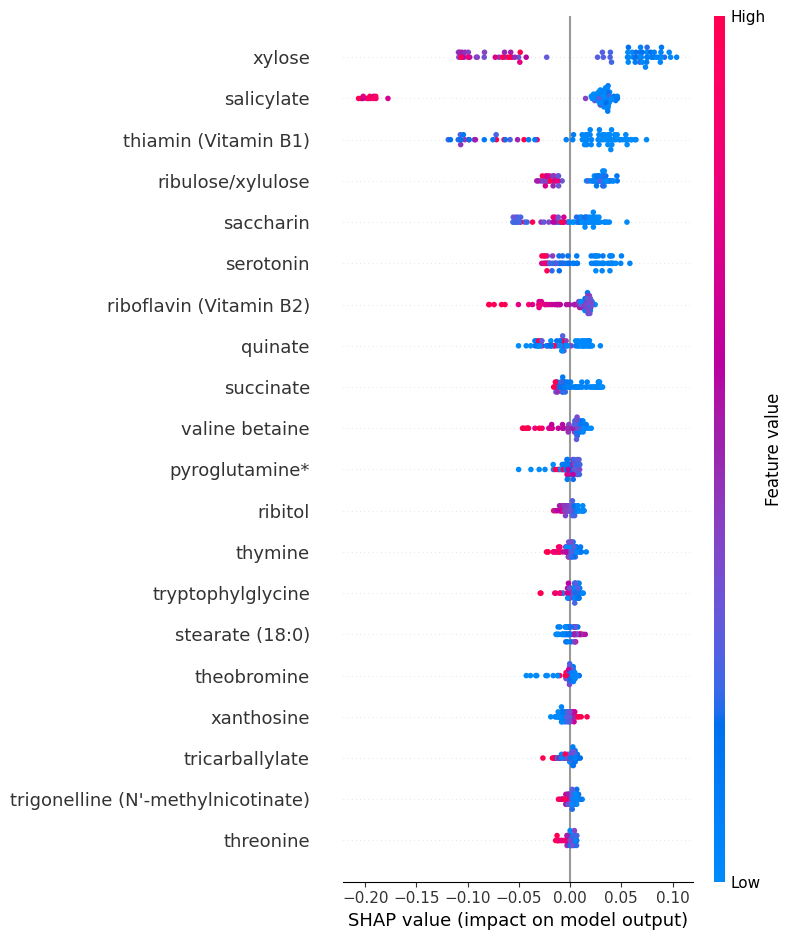

In [8]:
# Plot SHAP summary
shap_values_class1 = shap_values[:, :, 1]  # Shape: (74, 30)
print(shap_values_class1)
shap.summary_plot(shap_values[:,:,1], model_trainer.X_test)

In [9]:
model_trainer.X_test.head()

,xylose,xanthosine,valylglutamine,valine betaine,ursodeoxycholate sulfate (1),uracil,tyrosine,tryptophylglycine,trigonelline (N'-methylnicotinate),tricarballylate,...,serotonin,serine,salicylate,saccharin,ribulose/xylulose,riboflavin (Vitamin B2),ribitol,quinolinate,quinate,pyroglutamine*
165,2.506056e+06,392215.1875,227777.3594,84891.79688,8.238643e+06,38972908.00,235692128.0,123408.1016,4.211854e+05,1.387354e+08,...,8.522013e+05,1.547638e+08,2.312892e+05,4.472932e+05,297346.34380,3013518.250,35020.77340,138271.3064,5.401290e+06,9.703382e+05
33,1.054350e+06,413790.6951,990336.8947,71326.02586,4.607571e+07,17865980.13,158163385.5,345508.3051,7.068979e+05,6.845647e+07,...,3.602409e+05,5.808115e+07,1.687328e+06,6.814437e+06,313931.91410,2218333.136,114038.06430,311079.9309,8.145667e+07,9.047389e+06
15,5.419032e+04,359696.5781,264627.3886,192954.82240,5.113608e+07,14872194.92,132402821.3,133474.4423,2.172100e+06,4.054795e+07,...,8.540763e+05,9.135119e+07,2.904279e+05,2.037487e+05,69733.35278,2343550.737,95413.27579,271669.6345,9.374524e+06,3.553353e+06
312,1.264503e+07,227669.1992,204874.6123,84924.85914,2.823080e+07,25795284.91,352853919.2,130915.0340,1.444508e+07,2.603862e+07,...,4.933513e+06,2.322843e+08,1.159479e+07,4.224602e+06,833316.39050,2826606.269,48387.22763,211656.7214,1.590875e+08,1.229582e+06
57,1.552786e+06,354748.1563,178436.8920,19341.44730,8.116564e+06,54136692.00,200438096.0,165364.4522,2.381670e+07,7.633326e+07,...,6.354268e+06,9.058383e+07,3.112571e+06,2.586710e+05,626175.00000,3298984.750,187799.87500,160499.2031,3.048202e+06,1.551921e+06


In [10]:
print(shap_values[:][:][1][:,1])

[ 0.09807784 -0.00034284  0.00104683  0.00768184  0.00078467  0.00583008
  0.00010866 -0.00162685  0.00356541  0.00369065  0.00402615  0.00383739
 -0.06322474  0.0022927   0.00092704  0.00015287  0.00502356 -0.00315742
  0.00072064 -0.00154152  0.03682039 -0.0004507   0.0460456  -0.02076425
  0.04567464  0.01847484 -0.01032549 -0.00020379 -0.00729033 -0.00476341]


In [11]:
i = 13 # Example test instance
# SHAP sum and model prediction comparison

shap_sum = np.sum(shap_values[:][:][i][:,1]) + explainer.expected_value
model_prediction = model.predict_proba(model_trainer.X_test.iloc[i].values.reshape(1, -1))[0][1]

print(f"Expected Value: {explainer.expected_value}")

print(f"Model prediction: {model_prediction}")
print(f"Sum of SHAP values + expected value: {shap_sum}")

if np.isclose(shap_sum[1], model_prediction, atol=1e-6):
    print("SHAP sum matches the model prediction.")
else:
    print("Discrepancy between SHAP sum and model prediction.")

Expected Value: [0.37927431 0.62072569]
Model prediction: 0.8257666685166687
Sum of SHAP values + expected value: [0.58431528 0.82576667]
SHAP sum matches the model prediction.


In [24]:
# causal_inference.py
import pandas as pd
import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz
import numpy as np
import json
import random
from math import factorial
from sklearn.linear_model import LinearRegression

class CausalInference:
    def __init__(self, data, model, target_variable):
        self.data = data  # pandas DataFrame
        self.pc_graph = None
        self.model = model  # Trained machine learning model
        self.gamma = None  # Dictionary to hold normalized causal strengths gamma_i
        self.target_variable = target_variable  # Name of the target variable
        self.ida_graph = None
        self.regression_models = {} 

    def run_pc_algorithm(self, alpha=0.05):
        data_np = self.data.to_numpy()
        pc_result = pc(data_np, alpha, fisherz)
        self.pc_graph = pc_result.G
        return self.pc_graph

    def draw_graph(self, file_path):
        pyd = GraphUtils.to_pydot(self.pc_graph)
        pyd.write_png(file_path)

    def load_causal_strengths(self, json_file_path):
        """
        Load causal strengths (beta_i) from JSON file and compute gamma_i.
        """
        # Load causal effects from JSON file
        with open(json_file_path, 'r') as f:
            causal_effects_list = json.load(f)
        
        # Build the causal graph
        G = nx.DiGraph()

        # Step 1: Add all nodes (features) from self.data columns
        nodes = list(self.data.columns)
        G.add_nodes_from(nodes)

        # Step 2: Add edges based on the causal effects from the JSON file
        for item in causal_effects_list:
            pair = item['Pair']
            mean_causal_effect = item['Mean_Causal_Effect']
            if mean_causal_effect is None:
                continue  # Skip if causal effect is None
            # Split the pair into source and target
            source, target = pair.split('->')
            source = source.strip()
            target = target.strip()
            # Add edge to the graph with the causal effect as weight
            G.add_edge(source, target, weight=mean_causal_effect)

        # Save the graph with all nodes and edges
        self.ida_graph = G.copy()

        # Now, compute the total causal effect from each feature to the target variable
        features = self.data.columns.tolist()
        beta_dict = {}
        for feature in features:
            if feature == self.target_variable:
                continue
            # Find all paths from feature to target_variable
            try:
                paths = list(nx.all_simple_paths(G, source=feature, target=self.target_variable))
            except nx.NetworkXNoPath:
                continue  # No path from this feature to target variable
            total_effect = 0
            for path in paths:
                # Compute the product of the edge weights along the path
                effect = 1
                for i in range(len(path)-1):
                    edge_weight = G[path[i]][path[i+1]]['weight']
                    effect *= edge_weight
                total_effect += effect
            if total_effect != 0:
                beta_dict[feature] = total_effect

        # Compute gamma_i = |beta_i| / sum_j |beta_j|
        total_causal_effect = sum(abs(beta) for beta in beta_dict.values())
        if total_causal_effect == 0:
            # Avoid division by zero
            self.gamma = {k: 0.0 for k in features}
        else:
            self.gamma = {k: abs(beta_dict.get(k, 0.0)) / total_causal_effect for k in features}
        return self.gamma
    
    def get_topological_order(self, S):
        """
        Returns the topological order of variables after intervening on subset S.
        """
        # Create a copy of the causal graph to modify
        G_intervened = self.ida_graph.copy()
        
        # Remove incoming edges to features in S
        for feature in S:
            G_intervened.remove_edges_from(list(G_intervened.in_edges(feature)))

        # Add any missing nodes (isolated nodes)
        missing_nodes = set(self.data.columns) - set(G_intervened.nodes)
        G_intervened.add_nodes_from(missing_nodes)
        
        # Perform topological sort
        try:
            order = list(nx.topological_sort(G_intervened))
        except nx.NetworkXUnfeasible:
            raise ValueError("The causal graph contains cycles.")
        
        return order
    
    def get_parents(self, feature):
        """
        Returns the list of parent features for a given feature in the causal graph.
        """
        return list(self.ida_graph.predecessors(feature))

    def sample_marginal(self, feature):
        """
        Sample a value from the marginal distribution of the specified feature.
        """
        return self.data[feature].sample(1).iloc[0]

    def sample_conditional(self, feature, parent_values):
        """
        Sample a value for a feature conditioned on its parent features using precomputed regression model.
        """
        # Effective parents are those not in S and not the target variable
        effective_parents = [p for p in self.get_parents(feature) if p != self.target_variable]
        
        if not effective_parents:
            return self.sample_marginal(feature)

        # Create a unique key for the feature and its effective parents
        model_key = (feature, tuple(sorted(effective_parents)))  # Sorted for consistency

        # Check if a precomputed regression model exists for the feature and its effective parents
        if model_key not in self.regression_models:
            # Fit a regression model for this feature given its effective parents
            X = self.data[effective_parents].values
            y = self.data[feature].values
            reg = LinearRegression()
            reg.fit(X, y)

            # Estimate the standard deviation from residuals
            residuals = y - reg.predict(X)
            std = residuals.std()

            # Store the regression model and std in the dictionary
            self.regression_models[model_key] = (reg, std)

        # Use the precomputed regression model and std
        reg, std = self.regression_models[model_key]

        # Prepare parent values for prediction using NumPy arrays
        parent_values_array = np.array([parent_values[parent] for parent in effective_parents]).reshape(1, -1)
        mean = reg.predict(parent_values_array)[0]

        # Sample from a normal distribution centered at the predicted mean
        sampled_value = np.random.normal(mean, std)
        return sampled_value



    def compute_v_do(self, S, x_S, num_samples=50, class_index=1):
        samples = []
        # Get all features excluding the target variable
        all_features = [col for col in self.data.columns if col != self.target_variable]
        # Determine the topological order, including all features
        variables_order = self.get_topological_order(S)
        for _ in range(num_samples):
            sample = {}
            # Set intervened features
            for feature in S:
                sample[feature] = x_S[feature]
            # Sample non-intervened features
            for feature in variables_order:
                if feature in S or feature == self.target_variable:
                    continue  # Skip intervened features and the target variable
                parents = self.get_parents(feature)
                parents = [p for p in parents if p != self.target_variable]
                parent_values = {}
                for parent in parents:
                    if parent in S:
                        parent_values[parent] = x_S[parent]
                    else:
                        parent_values[parent] = sample[parent]
                if not parent_values:
                    sample[feature] = self.sample_marginal(feature)
                else:
                    sample[feature] = self.sample_conditional(feature, parent_values)
            # Assign values to features not included in the causal graph
            for feature in all_features:
                if feature not in sample and feature not in S:
                    # Sample from marginal distribution
                    sample[feature] = self.sample_marginal(feature)
            # Convert sample to DataFrame
            intervened_data = pd.DataFrame([sample])
            # Reorder columns to match training data
            intervened_data = intervened_data[self.model.feature_names_in_]
            # Get probability prediction for the specified class
            proba = self.model.predict_proba(intervened_data)[0][class_index]
            samples.append(proba)
        v_S = np.mean(samples)
        return v_S





    def compute_modified_shap_proba(self, x, num_samples=50, shap_num_samples=50, class_index=1):
        # Exclude the target variable from the features list
        features = [col for col in self.data.columns if col != self.target_variable]
        n_features = len(features)
        phi_causal = {feature: 0.0 for feature in features}

        # Precompute E[f(X)] using predict_proba
        data_without_target = self.data.drop(columns=[self.target_variable], errors='ignore')
        # Reorder columns to match training data
        data_without_target = data_without_target[self.model.feature_names_in_]
        E_fX = self.model.predict_proba(data_without_target)[:, class_index].mean()

        # Precompute f(x) using predict_proba
        x_ordered = x[self.model.feature_names_in_]
        f_x = self.model.predict_proba(x_ordered.to_frame().T)[0][class_index]

        # Monte Carlo approximation for Shapley values
        for _ in range(shap_num_samples):
            # Randomly select a subset S from features (excluding target variable)
            S_size = random.randint(0, n_features)
            S = random.sample(features, S_size)

            # For each feature i not in S
            for i in features:
                if i in S:
                    continue
                S_without_i = S.copy()
                S_with_i = S + [i]

                # x_S is the values of features in S
                x_S = x[S_without_i] if S_without_i else pd.Series(dtype=float)

                # x_Si is the values of features in S union {i}
                x_Si = x[S_with_i] if S_with_i else pd.Series(dtype=float)

                # Compute v(S)
                v_S = self.compute_v_do(S_without_i, x_S, num_samples=num_samples, class_index=class_index)

                # Compute v(S union {i})
                v_Si = self.compute_v_do(S_with_i, x_Si, num_samples=num_samples, class_index=class_index)

                # Compute weight w(S,i) = |S|!(n - |S| - 1)! / n!
                weight = (factorial(len(S_without_i)) * factorial(n_features - len(S_without_i) - 1)) / factorial(n_features)

                # Multiply by gamma_i
                gamma_i = self.gamma.get(i, 0.0)
                weight *= gamma_i

                # Marginal contribution
                delta_v = v_Si - v_S

                # Update phi_causal[i]
                phi_causal[i] += weight * delta_v

        # Normalize phi_causal
        sum_phi_causal = sum(phi_causal.values())

        if sum_phi_causal == 0:
            # Avoid division by zero
            phi_normalized = {k: 0.0 for k in phi_causal.keys()}
        else:
            scaling_factor = (f_x - E_fX) / sum_phi_causal
            phi_normalized = {k: v * scaling_factor for k, v in phi_causal.items()}

        return phi_normalized


In [25]:
print("Applying causal SHAP values...")
ci = CausalInference(data=model_trainer.X_train, model=model, target_variable='Group')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS.json')
print(ci.gamma)
X_train_scaled_df = pd.DataFrame(model_trainer.X_train, columns=model_trainer.X_train.columns)
X_test_scaled_df = pd.DataFrame(model_trainer.X_test, columns=model_trainer.X_test.columns)

Applying causal SHAP values...
{'xylose': 0.0, 'xanthosine': 0.0, 'valylglutamine': 0.0, 'valine betaine': 0.0, 'ursodeoxycholate sulfate (1)': 0.0, 'uracil': 0.0, 'tyrosine': 0.0, 'tryptophylglycine': 0.0, "trigonelline (N'-methylnicotinate)": 0.0, 'tricarballylate': 0.0, 'thymine': 0.0, 'threonine': 0.0, 'thiamin (Vitamin B1)': 0.0, 'theobromine': 0.0, 'syringic acid': 0.0, 'succinimide': 0.0, 'succinate': 0.0, 'stearate (18:0)': 0.0, 'stachydrine': 0.0, 'sphingosine': 0.0, 'serotonin': 0.0, 'serine': 0.0, 'salicylate': 0.0, 'saccharin': 0.0, 'ribulose/xylulose': 0.0, 'riboflavin (Vitamin B2)': 0.0, 'ribitol': 0.0, 'quinolinate': 0.0, 'quinate': 0.0, 'pyroglutamine*': 0.0}


In [26]:
x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)
phi_normalized = ci.compute_modified_shap_proba(x_instance)

# Print modified SHAP values
print("Modified Causal SHAP Values:")
for feature, value in phi_normalized.items():
    print(f"{feature}: {value}")

Modified Causal SHAP Values:
xylose: 0.0
xanthosine: 0.0
valylglutamine: 0.0
valine betaine: 0.0
ursodeoxycholate sulfate (1): 0.0
uracil: 0.0
tyrosine: 0.0
tryptophylglycine: 0.0
trigonelline (N'-methylnicotinate): 0.0
tricarballylate: 0.0
thymine: 0.0
threonine: 0.0
thiamin (Vitamin B1): 0.0
theobromine: 0.0
syringic acid: 0.0
succinimide: 0.0
succinate: 0.0
stearate (18:0): 0.0
stachydrine: 0.0
sphingosine: 0.0
serotonin: 0.0
serine: 0.0
salicylate: 0.0
saccharin: 0.0
ribulose/xylulose: 0.0
riboflavin (Vitamin B2): 0.0
ribitol: 0.0
quinolinate: 0.0
quinate: 0.0
pyroglutamine*: 0.0


In [70]:
# Compare standard SHAP and causal SHAP values
standard_shap_series = pd.Series(shap_values[i][:,1], index=X_test_scaled_df.columns)
causal_shap_series = pd.Series(phi_normalized, index=X_test_scaled_df.columns)

# Apply iterative feature deletion and addition to compare SHAP values
print("Comparing SHAP and Causal SHAP using feature deletion and addition...")
avg_output_standard_deletion = iterative_feature_deletion_with_avg_output_regression(
    model=model, input_features=x_instance, attribution_scores=standard_shap_series, top_k=4)

avg_output_causal_deletion = iterative_feature_deletion_with_avg_output_regression(
    model=model, input_features=x_instance, attribution_scores=causal_shap_series, top_k=4)

avg_output_standard_addition = iterative_feature_addition_with_avg_output_regression(
    model=model, input_features=x_instance, attribution_scores=standard_shap_series, top_k=4)

avg_output_causal_addition = iterative_feature_addition_with_avg_output_regression(
    model=model, input_features=x_instance, attribution_scores=causal_shap_series, top_k=4)

print(f"Average Output (Standard SHAP - Deletion): {avg_output_standard_deletion}")
print(f"Average Output (Cusal SHAP - Deletion): {avg_output_causal_deletion}")
print(f"Average Output (Standard SHAP - Addition): {avg_output_standard_addition}")
print(f"Average Output (Standard SHAP - Addition): {avg_output_standard_addition}")


Comparing SHAP and Causal SHAP using feature deletion and addition...
Average Output (Standard SHAP - Deletion): 1.0
Average Output (Cusal SHAP - Deletion): 1.0
Average Output (Standard SHAP - Addition): 1.0
Average Output (Standard SHAP - Addition): 1.0


#### Archive

In [6]:
# print("Performing feature selection using SHAP importance...")
# selected_features_shap = feature_selector.shap_importance(model_trainer.X_test, threshold=0.005)
# print("Feature selection (SHAP importance) completed.")

# print("Generating SHAP summary plot...")
# visualizer = Visualizer()
# shap_summary_path = result_dir + 'shap_summary.png'
# visualizer.plot_shap_summary(model, model_trainer.X_test, str(shap_summary_path))
# print(f"SHAP summary plot saved at: {shap_summary_path}")

# print("Performing causal inference...with SHAP selected and Group")
# causal_features = selected_features_shap.to_list() + ['Group']
# df_causal = df_encoded[causal_features]
# causal_inference = CausalInference(df_causal)
# causal_graph = causal_inference.run_pc_algorithm()
# print("Causal inference completed.")

# print("Drawing causal graph...")
# causal_graph_path = result_dir + 'causal_graph.png'
# causal_inference.draw_graph(str(causal_graph_path))
# print(f"Causal graph saved at: {causal_graph_path}")

# print("Writing report...")
# with open(report_file_path, 'w') as report_file:
#     report_file.write("First few rows of the dataset:\n")
#     report_file.write(df.head().to_string())
#     report_file.write("\n\n")
#     report_file.write("Best Parameters:\n")
#     report_file.write(str(best_params))
#     report_file.write("\n\n")
#     report_file.write(f"Accuracy: {accuracy * 100:.2f}%\n\n")
#     report_file.write("Classification Report:\n")
#     report_file.write(report)
#     report_file.write("\n\n")
#     report_file.write("Selected Features (Gini Importance):\n")
#     report_file.write(', '.join(selected_features_gini))
#     report_file.write("\n\n")
#     report_file.write("Selected Features (SHAP Importance):\n")
#     report_file.write(', '.join(selected_features_shap))
#     report_file.write("\n\n")
#     report_file.write(f"SHAP summary plot saved as '{shap_summary_path}'.\n\n")
#     report_file.write(f"Causal graph saved as '{causal_graph_path}'.\n")
# print("Report written successfully.")

# print(f"Report generated at '{report_file_path}'.")
# print("Process completed successfully.")
